# Simulating DSA-200 Images

From tyrones_stuff, simulate a very large image, e.g.:

`python sky_model.py --first ~/catalogs/first/first_14dec17.fits -o test_first.fits`

or

`python sky_model.py --first /fastpool/claw/catalogs/first/first_14dec17.fits --agn /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_AGNs_complete_1sqdeg.fits --sfg /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_SFGs_complete_1sqdeg.fits -o /fastpool/claw/images/dsa2k_first+trecsagnsfg_4096.fits --npix 4096 --target 0 0 1 1`

Details at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf.

TODO: add more sources and make larger area. be sure to set npix to produce correct pixel scale

The simulation process will apply image-plane modifications as they are applied by propagation and measurement (going "forward").
1. apply ionospheric screen
2. apply primary beam and cut out 16k x 16k field (~10 sq deg)
3. add noise
4. convolve with PSF

Then iterate over new screens and pointing directions to create a sequence of measurements of a "tile" (e.g., 5x5).a

## Setup

In [1]:
import os.path
from scipy.interpolate import RBFInterpolator, CloughTocher2DInterpolator
from multiprocess import Pool
from typing import Literal, Tuple, Union
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs
from astropy.io import fits

import numpy as np
from jax.scipy.signal import convolve
import jax.numpy as jnp
from jaxtyping import Array
import pandas as pd

In [2]:
from data import fits_image
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from interactive import toggle_images, plot_image, sequence_images

## Create image

In [3]:
#!cd /home/claw/code/tyrones_stuff

In [4]:
#!python sky_model.py --first /fastpool/claw/catalogs/first/first_14dec17.fits -o /fastpool/claw/images/test.fits --npix 1024  --target 0 0 0.25 0.25

In [5]:
#input_image = '/fastpool/claw/images/test.fits'
#image, imwcs = fits_image(input_image)
#print(image.std(), image.min(), image.max())
#plot_image(image, vmin=image.min(), vmax=image.max())

In [6]:
def compute_offsets(dxmodel, dymodel):
    # compute each row separately
    def calc_row(r):
        # all indices with row r
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()  
        xy[:, 0] = r
        row_offsets = np.stack((dxmodel(xy), dymodel(xy)), axis=-1)
        return row_offsets
    
    # Naive multiprocessing (computing each row separately):
    # Note: while this should be extremely parallelizable , something (likely the GIL)
    # is preventing us from achieving optimal performance. This seems to take about 3
    # minutes with multiprocessing (64 cores) and 4.5 minutes without. Thus, Amdahl's
    # law tells us that only about 25% of this task is parallelizable (though it
    # should be closer to 100%).
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(calc_row, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
        return res

    results = go()
    return np.concatenate(results)

def compute_interpolation(interp):
    def g(r):
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()
        xy[:, 0] = r
        return interp(xy)
    
    # naive multiprocessing, see above
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(g, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
                
        return res

    results = go()
    interp_img = np.stack(results, axis=0)
    return interp_img


In [7]:
def reference_sources_nvss(catalog, min_flux=270) -> Tuple[SkyCoord, Array]:
    nvss = pd.read_csv(catalog, sep=r"\s+")
    sorted_nvss = nvss.sort_values(by=["f"])

    # cut off refernce sources below a certain flux density
    sorted_nvss = sorted_nvss[sorted_nvss["f"] >= min_flux]

    # get coordinates of each reference source
    nvss_orig = sorted_nvss[["rah", "ram", "ras", "dd", "dm", "ds"]].to_numpy()

    # get flux of each reference source in Jy
    fluxes = sorted_nvss[["f"]].to_numpy().squeeze() / 1000

    # manually convert HMS:DMS into degrees
    nvss_ra = (
        15 * nvss_orig[:, 0]
        + (15 / 60) * nvss_orig[:, 1]
        + (15 / 3600) * nvss_orig[:, 2]
    )
    nvss_dec = (
        nvss_orig[:, 3] + (1 / 60) * nvss_orig[:, 4] + (1 / 3600) * nvss_orig[:, 5]
    )

    positions = np.stack((nvss_ra, nvss_dec), axis=-1)

    return SkyCoord(positions, unit=(u.deg, u.deg)), jnp.array(fluxes)

In [8]:
def gkern(l=5, sig=1.0):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`.
    Reaches a maximum of 1 at its center value
    """
    ax = jnp.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = jnp.exp(-0.5 * jnp.square(ax) / jnp.square(sig))
    kernel = jnp.outer(gauss, gauss)
    return kernel / kernel.max()

In [9]:
def pbcut(img, center, size):
    """ Multiple by Gaussian primary beam at location center (in (x,y) pixel coords) and width size (pixels).
    """
    pb_kernel = gkern(size, size/4)  # TODO figure out width
    return np.array(img[(center[0]-size//2):(center[0]+size//2), (center[1]-size//2):(center[1]+size//2)]*pb_kernel)

## 1. Read image

In [10]:
# Details on simulation at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf
#input_image = '/fastpool/claw/images/test.fits'  # toy image at 1350 MHz and FIRST catalog
input_image = '/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192.fits'

In [11]:
image, imwcs = fits_image(input_image)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [12]:
IMAGE_SIZE = image.shape[0]
CPU_COUNT = 2
WORKING_DIR = '/fastpool/claw/images/'
print(f'Image size: {IMAGE_SIZE}')

Image size: 8192


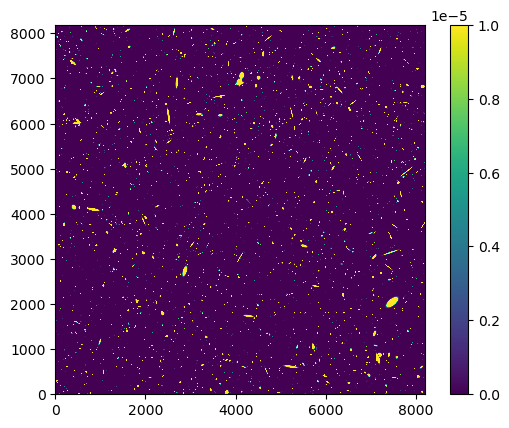

In [13]:
im = fits.open(input_image)[0].data.squeeze()
plot_image(im, vmin=im.min(), vmax=0.00001)

## 2. Add noise

In [40]:
noise_sigma = 1e-6
realbeam = False

if realbeam:
    psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
    psf_image, psf_wcs = fits_image(psf_filename)

    # normalization factor for core of PSF that overlaps input image
    psf_width = psf_image.squeeze().shape[0]
    psf_norm = psf_image.squeeze()[psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2,
                                   psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2].sum()

    print(psf_norm, psf_width, IMAGE_SIZE)
else:
    # overload with restoring beam
    pixscale = 4*3600/8192
    psf_image = gkern(l=64, sig=3.3/pixscale)
    psf_norm = psf_image.sum()

28.442507


In [43]:
hdu = fits.open(input_image)[0]
image = np.ma.masked_invalid(hdu.data.squeeze())
image.set_fill_value(0)
hdr = hdu.header
noise = np.random.normal(0, noise_sigma, size=image.shape)  # zero mean
noise_convolved = convolve(noise, psf_image/psf_norm, mode="same", method="fft")

print(noise_convolved.std())

1.5952321e-07


In [44]:
noise_convolved = np.array(noise_convolved)

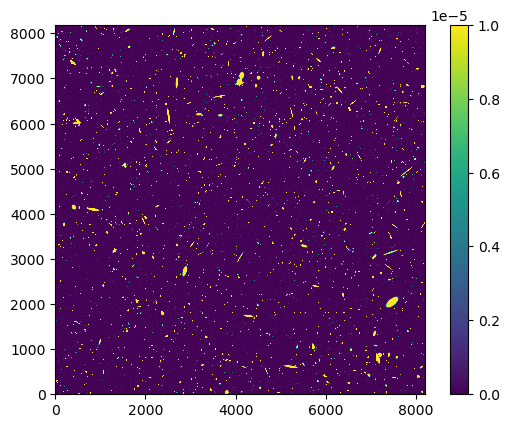

In [45]:
image_noise = image.filled()+noise_convolved
plot_image(image_noise, vmax=1e-5)

## 3. Convolve image with PSF 

In [48]:
# note that noise is double convolved
image_convolved = convolve(image_noise, psf_image/psf_norm, mode="same", method="fft")

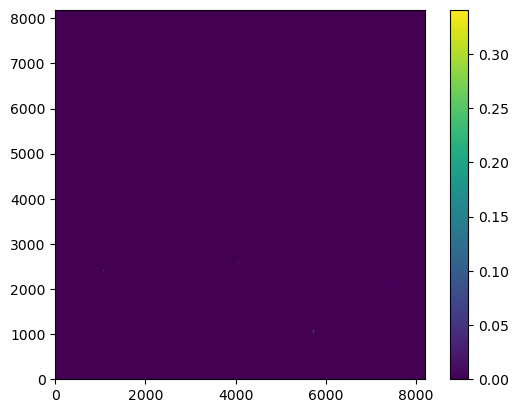

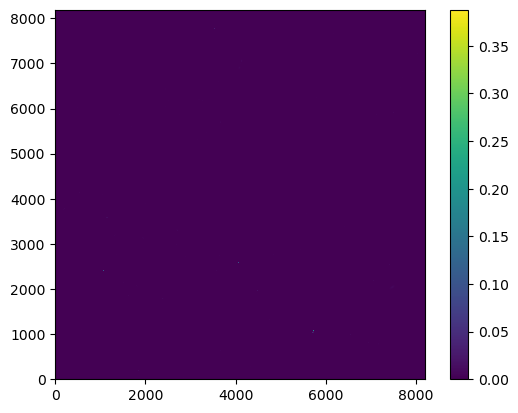

In [49]:
plot_image(image_convolved, vmax=image_convolved.max())
plot_image(im, vmax=im.max())

In [50]:
if realbeam:
    fits.writeto(input_image.replace('.fits', 'noiseconv.fits'), image_convolved, header=hdr, overwrite=True)
else:
    fits.writeto(input_image.replace('.fits', 'noiserestored.fits'), image_convolved, header=hdr, overwrite=True)

## Catalog of sky model

In [51]:
cd ../../tyrones_stuff/

/home/claw/code/tyrones_stuff


/home/claw/.conda/envs/py310/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [52]:
import catalog_utils
tbf, tbs, tba = catalog_utils.mask(#[[-1*u.deg, -1*u.deg], [1*u.deg, 1*u.deg]],
                                    [[0*u.deg, 0*u.deg], [0.25*u.deg, 0.25*u.deg]],
                                   first=catalog_utils.get_srcs('/fastpool/claw/catalogs/first/first_14dec17.fits', 'first'),
                                   sfg=catalog_utils.get_srcs('/fastpool/claw/catalogs/trecs/5sq_deg/catalogue_SFGs_complete_5sqdeg.fits', 'trecs-sfg'),
                                   agn=catalog_utils.get_srcs('/fastpool/claw/catalogs/trecs/5sq_deg/catalogue_AGNs_complete_5sqdeg.fits', 'trecs-agn'))

In [58]:
#sfg
dfs = tbs[['I1350', 'longitude', 'latitude']].to_pandas()
s = tbs
ecc = np.sqrt(s["e1"].value**2 + s["e2"].value**2)  # eccentricity                                                               
major = 1 / (1 - ecc) * s["size"].value
minor = 1 / (1 + ecc) * s["size"].value
rot = np.arctan2(s["e1"].value, s["e2"].value)  # position angle
dfs.insert(3, 'major', major)
dfs.insert(4, 'minor', minor)
dfs.insert(5, 'posang', rot)
dfs.insert(6, 'source', len(dfs)*['sfg'])
dfs.rename(columns={'I1350': 'FPEAK', 'longitude': 'RA', 'latitude': 'DEC'}, inplace=True)

#agn
s = tba
major = np.cast[float](tba['size'])
rs = np.cast[float](tba['Rs'])
minor = major * np.cast[float](rs)
posang = np.zeros_like(major)
dfa = tba[['I1350', 'longitude', 'latitude']].to_pandas()
dfa.insert(3, 'major', major)
dfa.insert(4, 'minor', minor)
dfa.insert(5, 'posang', posang)
dfa.insert(6, 'source', len(dfa)*['agn'])
dfa.rename(columns={'I1350': 'FPEAK', 'longitude': 'RA', 'latitude': 'DEC'}, inplace=True)

#first
dff = tbf[['FPEAK', 'RA', 'DEC', 'FITTED_MAJOR', 'FITTED_MINOR', 'POSANG']].to_pandas()
dff.insert(6, 'source', len(dff)*['first'])
dff.rename(columns={'FITTED_MAJOR': 'major', 'FITTED_MINOR': 'minor', 'POSANG': 'posang'}, inplace=True)

In [59]:
df = pd.concat([dfs, dfa, dff])

In [60]:
df

,FPEAK,RA,DEC,major,minor,posang,source
0,0.041819,0.061436,0.043855,11.014426,7.838243,0.809732,sfg
1,0.014644,0.160527,0.076825,1.747421,1.435020,2.998926,sfg
2,1.043475,0.183638,0.095511,10.951357,4.072782,0.484684,sfg
3,0.341989,0.242485,0.034869,6.208163,5.286959,-2.110326,sfg
4,0.013052,0.033070,0.069083,2.455973,2.137368,-0.706107,sfg
...,...,...,...,...,...,...,...
1,0.840000,0.165421,0.129481,7.180000,3.780000,17.299999,first
2,1.890000,0.154325,0.100892,5.410000,4.780000,87.900002,first
3,2.650000,0.225075,0.085942,6.310000,5.080000,33.500000,first
4,10.480000,0.048450,0.061247,6.470000,5.420000,32.200001,first


In [61]:
from astropy import coordinates
coordinates.SkyCoord(dfs.sort_values('FPEAK')[['RA', 'DEC']].to_numpy(), unit='deg')[-10:].to_string('hmsdms')

['00h00m54.9912107s +00d02m07.12247819s',
 '00h00m46.16761565s +00d02m37.40856081s',
 '00h00m06.62602231s +00d13m52.62242675s',
 '00h00m55.79164982s +00d04m32.96208143s',
 '00h00m24.9411732s +00d11m11.7816174s',
 '00h00m58.19641113s +00d02m05.52696615s',
 '00h00m27.36263931s +00d14m23.97841573s',
 '00h00m52.80504584s +00d01m51.32208109s',
 '00h00m52.96328902s +00d12m07.21440196s',
 '00h00m44.07318234s +00d05m43.83958876s']

In [63]:
df.to_csv(input_image.replace('.fits', 'catalog.csv'))